In [1]:
# 環境構築

!apt-get update
!apt-get install -y libsndfile1-dev
!pip install scipy
!pip install scikit-learn
!pip install librosa

/bin/bash: /home/allegro/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)
/bin/bash: /home/allegro/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
/bin/bash: /home/allegro/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/allegro/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/a

In [2]:
# clips 作成

SAMPLING_RATE = 44100 # 変更不可

clip_size = 81920 # 楽曲を再構築するパーツ1つあたりの大きさ
step_size = 20480 # clip をずらすときの大きさ
window_size = 10240 # CQT_CHROMA を取得するのに使用するサンプル数
hop_size = 640 # window をずらすときの大きさ

from scipy.io.wavfile import read, write
import glob
import os
import numpy as np
import librosa
import sys

if os.path.isfile("../data/out/clips.wav"):
    print("../data/out/clips.wav exists.")
    files = ["../data/out/clips.wav"]
else:
    # clips.npy をもとにデータを作成する 
    if os.path.isfile("../data/arrays/clips.npy"):
        print("loading ../data/arrays/clips.npy ...")
        clips = np.load("../data/arrays/clips.npy")
        print("creating ../data/out/clips.wav ...")
        write("../data/out/clips.wav", SAMPLING_RATE, clips.reshape((clips.shape[0] * clips.shape[1], )))
        files = ["../data/out/clips.wav"]
        
    # clips,npy がないとき /data/wav44100 内の WAV ファイルを参照する
    else:
        files = glob.glob("../data/wav44100/*.wav")
        #files = ["../data/wav44100/3DEmbodimentFromLines.wav"] # デバッグ用 
        
if len(files) == 0:
    print("WAV ファイルが見つかりませんでした。")
    sys.exit(1)
        
clips_filename = "../data/arrays/c" + str(clip_size) + "_s" + str(step_size) + "_f32_clips"

if os.path.isfile(clips_filename + ".npy"):
    print("loading " + clips_filename + ".npy ...")
    clips = np.load(clips_filename + ".npy")
else:
    print("creating " + clips_filename + ".npy ...")
    raw_data_list = [librosa.load(file, sr=SAMPLING_RATE)[0] for file in files] # 左の音だけ使う

    clips = np.zeros((0, clip_size), dtype=np.float32)
    for raw_data in raw_data_list:
        tmp = [raw_data[i:i + clip_size] for i in range(0, len(raw_data) - clip_size, step_size)]
        clips = np.vstack((clips, np.array(tmp)))
    np.save(clips_filename, clips)

print("The clip array has " + str(clips.shape[0]) + " clips.")

../data/out/clips.wav exists.
loading ../data/arrays/c81920_s20480_f32_clips.npy ...
The clip array has 57148 clips.


In [3]:
# cqt 作成

n_bins = 84

cqt_filename = clips_filename + "_w" + str(window_size) + "_h" + str(hop_size) + "_cqts"

if os.path.isfile(cqt_filename + ".npy"):
    print("loading " + cqt_filename + ".npy ...")
    cqts = np.load(cqt_filename + ".npy")
else:
    print("creating " + cqt_filename + ".npy ...")
    num = 0
    for clip in clips:
        print("cqt progress: clip " + str(num + 1) + " / " + str(len(clips)))
        
        tmp_cqt = librosa.cqt(clip, sr=SAMPLING_RATE, hop_length=hop_size, n_bins=n_bins)
        tmp_cqt = tmp_cqt.reshape((1, tmp_cqt.shape[0], tmp_cqt.shape[1]))
        
        if num == 0:
            cqts = tmp_cqt
        else:
            cqts = np.vstack((cqts, tmp_cqt))
            
        num += 1

    np.save(cqt_filename, cqts)
    
print("The cqt array has " + str(cqts.shape[0]) + " cqts.")
print("cqts.shape: " + str(cqts.shape))
print("Type(cqts[0][0][0]): " + str(type(cqts[0][0][0])))
print("np.max(cqts[0][0]): " + str(np.max(cqts[0][0])))

loading ../data/arrays/c81920_s20480_f32_clips_w10240_h640_cqts.npy ...
The cqt array has 57148 cqts.
cqts.shape: (57148, 84, 129)
Type(cqts[0][0][0]): <class 'numpy.complex64'>
np.max(cqts[0][0]): (0.021538047+0.007131239j)


In [4]:
# cqt_choroma 作成

def Preprocessing(array):
    array = np.abs(array)
    array = np.log(array + 1)
    array = array / np.log(np.finfo(np.float32).max)
    array = array.T
    return array

cqt_chroma_filename = clips_filename + "_w" + str(window_size) + "_h" + str(hop_size) + "_cqt_chromas"

if os.path.isfile(cqt_chroma_filename + ".npy"):
    print("loading " + cqt_chroma_filename + ".npy ...")
    cqt_chromas= np.load(cqt_chroma_filename + ".npy")
else:
    print("creating " + cqt_chroma_filename + ".npy ...")
    num = 0
    for cqt in cqts:
        print("cqt_chroma progress: clip " + str(num + 1) + " / " + str(len(cqts)))
        
        tmp_cqt_chroma = librosa.feature.chroma_cqt(C=cqt, sr=SAMPLING_RATE)
        tmp_cqt_chroma = Preprocessing(tmp_cqt_chroma)
        tmp_cqt_chroma = tmp_cqt_chroma.reshape((1, tmp_cqt_chroma.shape[0], tmp_cqt_chroma.shape[1]))
        
        if num == 0:
            cqt_chromas = tmp_cqt_chroma
        else:
            cqt_chromas = np.vstack((cqt_chromas, tmp_cqt_chroma))
            
        num += 1

    np.save(cqt_chroma_filename, cqt_chromas)
    
print("The cqt_chroma array has " + str(cqt_chromas.shape[0]) + " cqt_chromas.")
print("cqt_chromas.shape: " + str(cqt_chromas.shape)) # clip 番号、window 番号、 chroma 番号 になる
print("Type(cqt_chromas[0][0][0]): " + str(type(cqt_chromas[0][0][0])))
print("np.max(cqt_chromas[0][0]): " + str(np.max(cqt_chromas[0][0])))

loading ../data/arrays/c81920_s20480_f32_clips_w10240_h640_cqt_chromas.npy ...
The cqt_chroma array has 57148 cqt_chromas.
cqt_chromas.shape: (57148, 129, 12)
Type(cqt_chromas[0][0][0]): <class 'numpy.float32'>
np.max(cqt_chromas[0][0]): 0.0078125


In [5]:
# max_norm 作成

num_divide = 8

max_norm_filename = clips_filename + "_d" + str(num_divide) + "_max_norms"

if os.path.isfile(max_norm_filename + ".npy"):
    print("loading " + max_norm_filename + ".npy ...")
    max_norms= np.load(max_norm_filename + ".npy")
else:
    print("creating " + max_norm_filename + ".npy ...")
    num = 0
    for clip in clips:
        print("max_norm progress: clip " + str(num + 1) + " / " + str(len(clips)))
        max_norm = [np.max(clip[int((i / num_divide) * len(clip)):int(((i + 1) / num_divide) * len(clip))] ** 2) for i in range(num_divide)]
    
        if num == 0:
            max_norms = np.array(max_norm)
        else:
            max_norms = np.vstack((max_norms, np.array(max_norm)))
        num += 1
        
    np.save(max_norm_filename, max_norms)
    
print("The max_norm array has " + str(max_norms.shape[0]) + " max_norms.")
print("max_norms.shape: " + str(max_norms.shape))
print("Type(max_norms[0][0]): " + str(type(max_norms[0][0])))
print("np.max(max_norms[0]): " + str(np.max(max_norms[0])))

loading ../data/arrays/c81920_s20480_f32_clips_d8_max_norms.npy ...
The max_norm array has 57148 max_norms.
max_norms.shape: (57148, 8)
Type(max_norms[0][0]): <class 'numpy.float32'>
np.max(max_norms[0]): 0.0179649


In [6]:
# 学習データとテストデータに分ける

def normalize(array):
    if (np.sum(array) == 0):
        return array
    else:
        return array / np.sum(array)
    
cqt_chroma_sum_threshold = 0.01 # 次の window の sum が閾値に満たないときに除外します
test_data_rate = 0.1

window_num_per_clip = cqt_chromas.shape[1]

cqt_chromas = np.array([np.hstack((cqt_chromas[i], np.repeat(np.array([max_norms[i]]), cqt_chromas.shape[1], axis=0))) for i in range(len(max_norms))])
cqt_chromas = np.concatenate([cqt_chromas[:-1, :, :], cqt_chromas[1:, 0, :].reshape(cqt_chromas.shape[0] - 1, 1, cqt_chromas.shape[2])], 1)

p = np.random.permutation(len(cqt_chromas))
cqt_chromas = cqt_chromas[p]
clips = clips[p]

x = np.delete(cqt_chromas, np.where(np.sum(cqt_chromas[:,-1,:], axis=1) < cqt_chroma_sum_threshold)[0], axis=0)

x_test = x[:int(x.shape[0] * test_data_rate), :window_num_per_clip, :].reshape(int(x.shape[0] * test_data_rate), window_num_per_clip, x.shape[2], 1)
x_train = x[int(x.shape[0] * test_data_rate):, :window_num_per_clip, :].reshape(x.shape[0] - int(x.shape[0] * test_data_rate), window_num_per_clip, x.shape[2], 1)

y = np.array([x[:, window_num_per_clip, i] for i in range(x.shape[2])])
y_maxs = np.max(y, axis=1)
y_mins = np.min(y, axis=1)

y_tests =  np.array([(x[:int(x.shape[0] * test_data_rate), window_num_per_clip, i] - y_mins[i]) / (y_maxs[i] - y_mins[i]) for i in range(x.shape[2])])
y_trains = np.array([(x[int(x.shape[0] * test_data_rate):, window_num_per_clip, i] - y_mins[i]) / (y_maxs[i] - y_mins[i]) for i in range(x.shape[2])])

print("x_train.shape: " + str(x_train.shape))
print("x_test.shape: " + str(x_test.shape))
print("y_trains.shape: " + str(y_trains.shape))
print("y_tests.shape: " + str(y_tests.shape))

x_train.shape: (51409, 129, 20, 1)
x_test.shape: (5712, 129, 20, 1)
y_trains.shape: (20, 51409)
y_tests.shape: (20, 5712)


In [7]:
def plot_history(history):
    # 精度の履歴をプロット
    plt.plot(history.history['accuracy'],"o-",label="accuracy")
    plt.plot(history.history['val_accuracy'],"o-",label="val_acc")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
    plt.show()
 
    # 損失の履歴をプロット
    plt.plot(history.history['loss'],"o-",label="loss",)
    plt.plot(history.history['val_loss'],"o-",label="val_loss")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='lower right')
    plt.show()

In [8]:
# モデル作成

import keras

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, Input, MaxPooling2D
from keras.optimizers import Adam

learning_rate = 0.001

models = []
for i in range(x.shape[2]):
    model = keras.models.Sequential()
    model.add(Conv2D(32, (3, 1), activation="relu", input_shape=(window_num_per_clip, cqt_chromas.shape[2], 1)))
    model.add(MaxPooling2D(pool_size=(2, 1)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(units=1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=learning_rate),metrics=['accuracy'])

    model.build()
    model.summary()
    
    models.append(model)

2023-03-20 23:19:29.372014: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 23:19:29.666660: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-20 23:19:31.920135: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/allegro/miniconda3/lib/
2023-03-20 23:19:31.925793: W tensorflow/compiler/xla/st

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 20, 32)       128       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 20, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 20, 32)        0         
                                                                 
 flatten (Flatten)           (None, 40320)             0         
                                                                 
 dense (Dense)               (None, 1)                 40321     
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                        

built without NUMA support.
2023-03-20 23:19:41.345906: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1700] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.
2023-03-20 23:19:41.345935: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-20 23:19:41.345967: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5424 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 127, 20, 32)       128       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 20, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 63, 20, 32)        0         
                                                                 
 flatten_3 (Flatten)         (None, 40320)             0         
                                                                 
 dense_3 (Dense)             (None, 1)                 40321     
                                                                 
 activation_3 (Activation)   (None, 1)                 0         
                                                      

 dropout_9 (Dropout)         (None, 63, 20, 32)        0         
                                                                 
 flatten_9 (Flatten)         (None, 40320)             0         
                                                                 
 dense_9 (Dense)             (None, 1)                 40321     
                                                                 
 activation_9 (Activation)   (None, 1)                 0         
                                                                 
Total params: 40,449
Trainable params: 40,449
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 127, 20, 32)       128       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 63, 20, 32) 

Total params: 40,449
Trainable params: 40,449
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 127, 20, 32)       128       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 63, 20, 32)       0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 63, 20, 32)        0         
                                                                 
 flatten_16 (Flatten)        (None, 40320)             0         
                                                                 
 dense_16 (Dense)            (None, 1)                 40321     
                                                 

In [9]:
# 学習
batch_size = 64
epochs = 200

data_name = "c" + str(clip_size) + "_s" + str(step_size) + "_w" + str(window_size) + "_h" + str(hop_size) + "_d" + str(num_divide)

histories = []
for i in range(x.shape[2]):
    model_name = "independent_" + data_name + "_batch" + str(batch_size) + "_e" + str(epochs) + "_" + str(i)

    histories.append(models[i].fit(x_train, y_trains[i],
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_tests[i])))

    models[i].save("../data/models/" + model_name)

Epoch 1/200


2023-03-20 23:19:43.743282: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-03-20 23:19:47.289347: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-20 23:19:51.661285: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-20 23:19:51.695030: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-20 23:19:51.695085: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:85] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-03-20 23:19:51.736234: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-20 23:19:51.73

804/804 [==============================] - 18s 6ms/step - loss: 0.6213 - accuracy: 0.5013 - val_loss: 0.6097 - val_accuracy: 0.5103
Epoch 2/200
804/804 [==============================] - 5s 6ms/step - loss: 0.6057 - accuracy: 0.5020 - val_loss: 0.5854 - val_accuracy: 0.5110
Epoch 3/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5797 - accuracy: 0.5144 - val_loss: 0.5635 - val_accuracy: 0.5271
Epoch 4/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5617 - accuracy: 0.5233 - val_loss: 0.5481 - val_accuracy: 0.5312
Epoch 5/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5484 - accuracy: 0.5268 - val_loss: 0.5360 - val_accuracy: 0.5329
Epoch 6/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5357 - accuracy: 0.5306 - val_loss: 0.5244 - val_accuracy: 0.5387
Epoch 7/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5236 - accuracy: 0.5337 - val_loss: 0.5103 - val_accuracy: 0.5439
Epoch 8/20

804/804 [==============================] - 5s 6ms/step - loss: 0.4614 - accuracy: 0.5512 - val_loss: 0.4571 - val_accuracy: 0.5586
Epoch 59/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4605 - accuracy: 0.5515 - val_loss: 0.4568 - val_accuracy: 0.5593
Epoch 60/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4606 - accuracy: 0.5517 - val_loss: 0.4594 - val_accuracy: 0.5590
Epoch 61/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4597 - accuracy: 0.5528 - val_loss: 0.4545 - val_accuracy: 0.5597
Epoch 62/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4610 - accuracy: 0.5515 - val_loss: 0.4579 - val_accuracy: 0.5550
Epoch 63/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4611 - accuracy: 0.5508 - val_loss: 0.4538 - val_accuracy: 0.5578
Epoch 64/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4602 - accuracy: 0.5523 - val_loss: 0.4555 - val_accuracy: 0.5586
Epoch

Epoch 115/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4518 - accuracy: 0.5547 - val_loss: 0.4470 - val_accuracy: 0.5618
Epoch 116/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4514 - accuracy: 0.5547 - val_loss: 0.4471 - val_accuracy: 0.5613
Epoch 117/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4507 - accuracy: 0.5548 - val_loss: 0.4480 - val_accuracy: 0.5604
Epoch 118/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4510 - accuracy: 0.5548 - val_loss: 0.4471 - val_accuracy: 0.5616
Epoch 119/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4513 - accuracy: 0.5552 - val_loss: 0.4488 - val_accuracy: 0.5604
Epoch 120/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4514 - accuracy: 0.5544 - val_loss: 0.4464 - val_accuracy: 0.5607
Epoch 121/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4509 - accuracy: 0.5550 - val_loss: 0.4470 - val_ac

INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch64_e200_0/assets


INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch64_e200_0/assets


Epoch 1/200
 11/804 [..............................] - ETA: 8s - loss: 0.6825 - accuracy: 0.4489

2023-03-20 23:36:47.384587: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


804/804 [==============================] - 6s 7ms/step - loss: 0.6440 - accuracy: 0.5009 - val_loss: 0.6451 - val_accuracy: 0.4989
Epoch 2/200
804/804 [==============================] - 5s 6ms/step - loss: 0.6398 - accuracy: 0.5019 - val_loss: 0.6371 - val_accuracy: 0.4989
Epoch 3/200
804/804 [==============================] - 5s 7ms/step - loss: 0.6260 - accuracy: 0.5019 - val_loss: 0.6147 - val_accuracy: 0.4989
Epoch 4/200
804/804 [==============================] - 5s 7ms/step - loss: 0.5995 - accuracy: 0.4996 - val_loss: 0.5873 - val_accuracy: 0.4979
Epoch 5/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5748 - accuracy: 0.4910 - val_loss: 0.5606 - val_accuracy: 0.4879
Epoch 6/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5561 - accuracy: 0.4818 - val_loss: 0.5410 - val_accuracy: 0.4806
Epoch 7/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5411 - accuracy: 0.4749 - val_loss: 0.5283 - val_accuracy: 0.4662
Epoch 8/200

804/804 [==============================] - 5s 6ms/step - loss: 0.4765 - accuracy: 0.4643 - val_loss: 0.4630 - val_accuracy: 0.4664
Epoch 59/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4777 - accuracy: 0.4645 - val_loss: 0.4641 - val_accuracy: 0.4690
Epoch 60/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4768 - accuracy: 0.4652 - val_loss: 0.4631 - val_accuracy: 0.4730
Epoch 61/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4770 - accuracy: 0.4654 - val_loss: 0.4617 - val_accuracy: 0.4706
Epoch 62/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4759 - accuracy: 0.4650 - val_loss: 0.4630 - val_accuracy: 0.4699
Epoch 63/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4763 - accuracy: 0.4651 - val_loss: 0.4646 - val_accuracy: 0.4785
Epoch 64/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4756 - accuracy: 0.4657 - val_loss: 0.4623 - val_accuracy: 0.4639
Epoch

Epoch 115/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4705 - accuracy: 0.4651 - val_loss: 0.4579 - val_accuracy: 0.4646
Epoch 116/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4705 - accuracy: 0.4649 - val_loss: 0.4607 - val_accuracy: 0.4727
Epoch 117/200
804/804 [==============================] - 5s 7ms/step - loss: 0.4710 - accuracy: 0.4655 - val_loss: 0.4594 - val_accuracy: 0.4725
Epoch 118/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4714 - accuracy: 0.4664 - val_loss: 0.4571 - val_accuracy: 0.4737
Epoch 119/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4703 - accuracy: 0.4664 - val_loss: 0.4565 - val_accuracy: 0.4746
Epoch 120/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4711 - accuracy: 0.4652 - val_loss: 0.4568 - val_accuracy: 0.4701
Epoch 121/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4701 - accuracy: 0.4668 - val_loss: 0.4568 - val_ac

INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch64_e200_1/assets


INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch64_e200_1/assets


Epoch 1/200
 15/804 [..............................] - ETA: 6s - loss: 0.6431 - accuracy: 0.5031

2023-03-20 23:53:50.753534: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


804/804 [==============================] - 6s 7ms/step - loss: 0.6219 - accuracy: 0.5019 - val_loss: 0.6258 - val_accuracy: 0.4900
Epoch 2/200
804/804 [==============================] - 5s 6ms/step - loss: 0.6179 - accuracy: 0.5021 - val_loss: 0.6234 - val_accuracy: 0.4900
Epoch 3/200
804/804 [==============================] - 5s 6ms/step - loss: 0.6075 - accuracy: 0.5021 - val_loss: 0.6065 - val_accuracy: 0.4900
Epoch 4/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5917 - accuracy: 0.5031 - val_loss: 0.5912 - val_accuracy: 0.4918
Epoch 5/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5768 - accuracy: 0.5093 - val_loss: 0.5758 - val_accuracy: 0.4968
Epoch 6/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5641 - accuracy: 0.5158 - val_loss: 0.5655 - val_accuracy: 0.5014
Epoch 7/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5518 - accuracy: 0.5210 - val_loss: 0.5514 - val_accuracy: 0.5105
Epoch 8/200

804/804 [==============================] - 5s 6ms/step - loss: 0.4714 - accuracy: 0.5468 - val_loss: 0.4741 - val_accuracy: 0.5418
Epoch 59/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4698 - accuracy: 0.5470 - val_loss: 0.4724 - val_accuracy: 0.5417
Epoch 60/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4705 - accuracy: 0.5466 - val_loss: 0.4747 - val_accuracy: 0.5436
Epoch 61/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4698 - accuracy: 0.5471 - val_loss: 0.4741 - val_accuracy: 0.5422
Epoch 62/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4704 - accuracy: 0.5465 - val_loss: 0.4727 - val_accuracy: 0.5424
Epoch 63/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4686 - accuracy: 0.5474 - val_loss: 0.4718 - val_accuracy: 0.5413
Epoch 64/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4688 - accuracy: 0.5472 - val_loss: 0.4721 - val_accuracy: 0.5417
Epoch

Epoch 115/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4634 - accuracy: 0.5492 - val_loss: 0.4731 - val_accuracy: 0.5446
Epoch 116/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4617 - accuracy: 0.5492 - val_loss: 0.4686 - val_accuracy: 0.5446
Epoch 117/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4623 - accuracy: 0.5512 - val_loss: 0.4688 - val_accuracy: 0.5446
Epoch 118/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4615 - accuracy: 0.5497 - val_loss: 0.4688 - val_accuracy: 0.5432
Epoch 119/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4605 - accuracy: 0.5514 - val_loss: 0.4693 - val_accuracy: 0.5452
Epoch 120/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4607 - accuracy: 0.5497 - val_loss: 0.4681 - val_accuracy: 0.5448
Epoch 121/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4607 - accuracy: 0.5505 - val_loss: 0.4693 - val_ac

INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch64_e200_2/assets


INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch64_e200_2/assets


Epoch 1/200
 11/804 [..............................] - ETA: 8s - loss: 0.6511 - accuracy: 0.4460

2023-03-21 00:10:42.946219: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


804/804 [==============================] - 6s 7ms/step - loss: 0.6101 - accuracy: 0.4973 - val_loss: 0.6071 - val_accuracy: 0.4923
Epoch 2/200
804/804 [==============================] - 5s 6ms/step - loss: 0.6061 - accuracy: 0.4978 - val_loss: 0.6021 - val_accuracy: 0.4923
Epoch 3/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5951 - accuracy: 0.4978 - val_loss: 0.5901 - val_accuracy: 0.4925
Epoch 4/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5793 - accuracy: 0.4998 - val_loss: 0.5697 - val_accuracy: 0.4958
Epoch 5/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5646 - accuracy: 0.5062 - val_loss: 0.5590 - val_accuracy: 0.5046
Epoch 6/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5510 - accuracy: 0.5122 - val_loss: 0.5446 - val_accuracy: 0.5063
Epoch 7/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5400 - accuracy: 0.5153 - val_loss: 0.5330 - val_accuracy: 0.5117
Epoch 8/200

804/804 [==============================] - 5s 6ms/step - loss: 0.4716 - accuracy: 0.5331 - val_loss: 0.4686 - val_accuracy: 0.5327
Epoch 59/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4692 - accuracy: 0.5340 - val_loss: 0.4676 - val_accuracy: 0.5320
Epoch 60/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4704 - accuracy: 0.5330 - val_loss: 0.4674 - val_accuracy: 0.5315
Epoch 61/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4694 - accuracy: 0.5343 - val_loss: 0.4677 - val_accuracy: 0.5322
Epoch 62/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4698 - accuracy: 0.5326 - val_loss: 0.4699 - val_accuracy: 0.5334
Epoch 63/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4687 - accuracy: 0.5341 - val_loss: 0.4678 - val_accuracy: 0.5322
Epoch 64/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4689 - accuracy: 0.5341 - val_loss: 0.4684 - val_accuracy: 0.5329
Epoch

Epoch 115/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4580 - accuracy: 0.5370 - val_loss: 0.4587 - val_accuracy: 0.5340
Epoch 116/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4571 - accuracy: 0.5368 - val_loss: 0.4588 - val_accuracy: 0.5331
Epoch 117/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4569 - accuracy: 0.5371 - val_loss: 0.4632 - val_accuracy: 0.5331
Epoch 118/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4586 - accuracy: 0.5363 - val_loss: 0.4595 - val_accuracy: 0.5331
Epoch 119/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4572 - accuracy: 0.5377 - val_loss: 0.4594 - val_accuracy: 0.5326
Epoch 120/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4577 - accuracy: 0.5361 - val_loss: 0.4587 - val_accuracy: 0.5345
Epoch 121/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4577 - accuracy: 0.5373 - val_loss: 0.4579 - val_ac

INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch64_e200_3/assets


INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch64_e200_3/assets


Epoch 1/200
 15/804 [..............................] - ETA: 6s - loss: 0.6377 - accuracy: 0.4615

2023-03-21 00:27:43.916807: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


804/804 [==============================] - 6s 7ms/step - loss: 0.5901 - accuracy: 0.4999 - val_loss: 0.5828 - val_accuracy: 0.5054
Epoch 2/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5850 - accuracy: 0.5003 - val_loss: 0.5765 - val_accuracy: 0.5054
Epoch 3/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5737 - accuracy: 0.5004 - val_loss: 0.5613 - val_accuracy: 0.5058
Epoch 4/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5597 - accuracy: 0.5020 - val_loss: 0.5489 - val_accuracy: 0.5109
Epoch 5/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5467 - accuracy: 0.5066 - val_loss: 0.5355 - val_accuracy: 0.5137
Epoch 6/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5354 - accuracy: 0.5112 - val_loss: 0.5245 - val_accuracy: 0.5187
Epoch 7/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5253 - accuracy: 0.5142 - val_loss: 0.5164 - val_accuracy: 0.5243
Epoch 8/200

804/804 [==============================] - 5s 6ms/step - loss: 0.4833 - accuracy: 0.5219 - val_loss: 0.4701 - val_accuracy: 0.5313
Epoch 59/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4832 - accuracy: 0.5225 - val_loss: 0.4685 - val_accuracy: 0.5327
Epoch 60/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4837 - accuracy: 0.5204 - val_loss: 0.4706 - val_accuracy: 0.5308
Epoch 61/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4821 - accuracy: 0.5219 - val_loss: 0.4688 - val_accuracy: 0.5324
Epoch 62/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4816 - accuracy: 0.5237 - val_loss: 0.4685 - val_accuracy: 0.5333
Epoch 63/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4826 - accuracy: 0.5222 - val_loss: 0.4691 - val_accuracy: 0.5327
Epoch 64/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4824 - accuracy: 0.5224 - val_loss: 0.4718 - val_accuracy: 0.5317
Epoch

Epoch 115/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4715 - accuracy: 0.5252 - val_loss: 0.4568 - val_accuracy: 0.5345
Epoch 116/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4701 - accuracy: 0.5253 - val_loss: 0.4575 - val_accuracy: 0.5341
Epoch 117/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4700 - accuracy: 0.5265 - val_loss: 0.4593 - val_accuracy: 0.5348
Epoch 118/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4696 - accuracy: 0.5253 - val_loss: 0.4548 - val_accuracy: 0.5352
Epoch 119/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4712 - accuracy: 0.5258 - val_loss: 0.4555 - val_accuracy: 0.5347
Epoch 120/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4695 - accuracy: 0.5261 - val_loss: 0.4544 - val_accuracy: 0.5357
Epoch 121/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4699 - accuracy: 0.5258 - val_loss: 0.4562 - val_ac

INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch64_e200_4/assets


INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch64_e200_4/assets


Epoch 1/200
 13/804 [..............................] - ETA: 6s - loss: 0.6142 - accuracy: 0.5060

2023-03-21 00:44:33.943787: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


804/804 [==============================] - 6s 7ms/step - loss: 0.5810 - accuracy: 0.5034 - val_loss: 0.5779 - val_accuracy: 0.4907
Epoch 2/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5713 - accuracy: 0.5035 - val_loss: 0.5653 - val_accuracy: 0.4907
Epoch 3/200
804/804 [==============================] - 5s 7ms/step - loss: 0.5571 - accuracy: 0.5040 - val_loss: 0.5521 - val_accuracy: 0.4916
Epoch 4/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5444 - accuracy: 0.5076 - val_loss: 0.5423 - val_accuracy: 0.4974
Epoch 5/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5345 - accuracy: 0.5106 - val_loss: 0.5332 - val_accuracy: 0.4995
Epoch 6/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5268 - accuracy: 0.5124 - val_loss: 0.5273 - val_accuracy: 0.5004
Epoch 7/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5218 - accuracy: 0.5141 - val_loss: 0.5208 - val_accuracy: 0.4989
Epoch 8/200

804/804 [==============================] - 5s 6ms/step - loss: 0.4851 - accuracy: 0.5209 - val_loss: 0.4852 - val_accuracy: 0.5103
Epoch 59/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4841 - accuracy: 0.5224 - val_loss: 0.4825 - val_accuracy: 0.5100
Epoch 60/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4850 - accuracy: 0.5209 - val_loss: 0.4830 - val_accuracy: 0.5088
Epoch 61/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4843 - accuracy: 0.5212 - val_loss: 0.4834 - val_accuracy: 0.5103
Epoch 62/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4832 - accuracy: 0.5226 - val_loss: 0.4842 - val_accuracy: 0.5089
Epoch 63/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4839 - accuracy: 0.5213 - val_loss: 0.4837 - val_accuracy: 0.5089
Epoch 64/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4838 - accuracy: 0.5210 - val_loss: 0.4828 - val_accuracy: 0.5107
Epoch

Epoch 115/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4769 - accuracy: 0.5245 - val_loss: 0.4781 - val_accuracy: 0.5126
Epoch 116/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4769 - accuracy: 0.5246 - val_loss: 0.4779 - val_accuracy: 0.5121
Epoch 117/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4779 - accuracy: 0.5231 - val_loss: 0.4797 - val_accuracy: 0.5142
Epoch 118/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4778 - accuracy: 0.5229 - val_loss: 0.4772 - val_accuracy: 0.5123
Epoch 119/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4774 - accuracy: 0.5232 - val_loss: 0.4809 - val_accuracy: 0.5135
Epoch 120/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4770 - accuracy: 0.5244 - val_loss: 0.4772 - val_accuracy: 0.5138
Epoch 121/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4761 - accuracy: 0.5250 - val_loss: 0.4790 - val_ac

INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch64_e200_5/assets


INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch64_e200_5/assets


Epoch 1/200
 13/804 [..............................] - ETA: 7s - loss: 0.6803 - accuracy: 0.4603

2023-03-21 01:01:44.405477: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


804/804 [==============================] - 6s 7ms/step - loss: 0.5990 - accuracy: 0.4962 - val_loss: 0.5922 - val_accuracy: 0.4967
Epoch 2/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5883 - accuracy: 0.4970 - val_loss: 0.5817 - val_accuracy: 0.4967
Epoch 3/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5787 - accuracy: 0.4972 - val_loss: 0.5740 - val_accuracy: 0.4960
Epoch 4/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5728 - accuracy: 0.4979 - val_loss: 0.5693 - val_accuracy: 0.4963
Epoch 5/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5684 - accuracy: 0.4991 - val_loss: 0.5655 - val_accuracy: 0.4979
Epoch 6/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5649 - accuracy: 0.5004 - val_loss: 0.5624 - val_accuracy: 0.5012
Epoch 7/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5597 - accuracy: 0.5025 - val_loss: 0.5567 - val_accuracy: 0.5005
Epoch 8/200

804/804 [==============================] - 5s 6ms/step - loss: 0.4910 - accuracy: 0.5222 - val_loss: 0.4879 - val_accuracy: 0.5254
Epoch 59/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4913 - accuracy: 0.5230 - val_loss: 0.4960 - val_accuracy: 0.5250
Epoch 60/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4908 - accuracy: 0.5228 - val_loss: 0.4868 - val_accuracy: 0.5236
Epoch 61/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4912 - accuracy: 0.5220 - val_loss: 0.4850 - val_accuracy: 0.5243
Epoch 62/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4909 - accuracy: 0.5213 - val_loss: 0.4871 - val_accuracy: 0.5238
Epoch 63/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4923 - accuracy: 0.5220 - val_loss: 0.4883 - val_accuracy: 0.5259
Epoch 64/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4910 - accuracy: 0.5224 - val_loss: 0.4884 - val_accuracy: 0.5254
Epoch

Epoch 115/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4888 - accuracy: 0.5222 - val_loss: 0.4846 - val_accuracy: 0.5236
Epoch 116/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4880 - accuracy: 0.5229 - val_loss: 0.4891 - val_accuracy: 0.5266
Epoch 117/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4883 - accuracy: 0.5226 - val_loss: 0.4877 - val_accuracy: 0.5263
Epoch 118/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4894 - accuracy: 0.5224 - val_loss: 0.4880 - val_accuracy: 0.5261
Epoch 119/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4880 - accuracy: 0.5230 - val_loss: 0.4865 - val_accuracy: 0.5256
Epoch 120/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4886 - accuracy: 0.5232 - val_loss: 0.4864 - val_accuracy: 0.5270
Epoch 121/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4877 - accuracy: 0.5237 - val_loss: 0.4875 - val_ac

INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch64_e200_6/assets


INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch64_e200_6/assets


Epoch 1/200
  9/804 [..............................] - ETA: 10s - loss: 0.6614 - accuracy: 0.4809

2023-03-21 01:18:39.017822: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/dropout_7/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


804/804 [==============================] - 6s 7ms/step - loss: 0.6048 - accuracy: 0.4996 - val_loss: 0.6006 - val_accuracy: 0.5035
Epoch 2/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5995 - accuracy: 0.4999 - val_loss: 0.5955 - val_accuracy: 0.5035
Epoch 3/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5894 - accuracy: 0.4999 - val_loss: 0.5832 - val_accuracy: 0.5035
Epoch 4/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5798 - accuracy: 0.5003 - val_loss: 0.5758 - val_accuracy: 0.5033
Epoch 5/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5733 - accuracy: 0.5011 - val_loss: 0.5695 - val_accuracy: 0.5051
Epoch 6/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5678 - accuracy: 0.5037 - val_loss: 0.5631 - val_accuracy: 0.5065
Epoch 7/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5610 - accuracy: 0.5075 - val_loss: 0.5556 - val_accuracy: 0.5128
Epoch 8/200

804/804 [==============================] - 5s 6ms/step - loss: 0.4910 - accuracy: 0.5376 - val_loss: 0.4808 - val_accuracy: 0.5455
Epoch 59/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4906 - accuracy: 0.5376 - val_loss: 0.4775 - val_accuracy: 0.5506
Epoch 60/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4911 - accuracy: 0.5376 - val_loss: 0.4786 - val_accuracy: 0.5490
Epoch 61/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4900 - accuracy: 0.5384 - val_loss: 0.4823 - val_accuracy: 0.5485
Epoch 62/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4894 - accuracy: 0.5378 - val_loss: 0.4770 - val_accuracy: 0.5508
Epoch 63/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4893 - accuracy: 0.5376 - val_loss: 0.4767 - val_accuracy: 0.5495
Epoch 64/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4895 - accuracy: 0.5381 - val_loss: 0.4771 - val_accuracy: 0.5509
Epoch

Epoch 115/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4882 - accuracy: 0.5380 - val_loss: 0.4735 - val_accuracy: 0.5476
Epoch 116/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4882 - accuracy: 0.5381 - val_loss: 0.4760 - val_accuracy: 0.5481
Epoch 117/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4865 - accuracy: 0.5390 - val_loss: 0.4751 - val_accuracy: 0.5494
Epoch 118/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4874 - accuracy: 0.5386 - val_loss: 0.4743 - val_accuracy: 0.5487
Epoch 119/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4873 - accuracy: 0.5379 - val_loss: 0.4747 - val_accuracy: 0.5480
Epoch 120/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4879 - accuracy: 0.5378 - val_loss: 0.4747 - val_accuracy: 0.5483
Epoch 121/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4884 - accuracy: 0.5370 - val_loss: 0.4741 - val_ac

INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch64_e200_7/assets


INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch64_e200_7/assets


Epoch 1/200
  7/804 [..............................] - ETA: 7s - loss: 0.6131 - accuracy: 0.4688  

2023-03-21 01:35:32.648569: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


804/804 [==============================] - 6s 7ms/step - loss: 0.5461 - accuracy: 0.4987 - val_loss: 0.5443 - val_accuracy: 0.4954
Epoch 2/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5399 - accuracy: 0.4991 - val_loss: 0.5381 - val_accuracy: 0.4954
Epoch 3/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5292 - accuracy: 0.4992 - val_loss: 0.5268 - val_accuracy: 0.4954
Epoch 4/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5199 - accuracy: 0.4997 - val_loss: 0.5193 - val_accuracy: 0.4954
Epoch 5/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5127 - accuracy: 0.5004 - val_loss: 0.5123 - val_accuracy: 0.4974
Epoch 6/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5067 - accuracy: 0.5015 - val_loss: 0.5058 - val_accuracy: 0.4986
Epoch 7/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5017 - accuracy: 0.5017 - val_loss: 0.5002 - val_accuracy: 0.4995
Epoch 8/200

804/804 [==============================] - 5s 6ms/step - loss: 0.4449 - accuracy: 0.5123 - val_loss: 0.4455 - val_accuracy: 0.5105
Epoch 59/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4451 - accuracy: 0.5121 - val_loss: 0.4459 - val_accuracy: 0.5107
Epoch 60/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4450 - accuracy: 0.5120 - val_loss: 0.4467 - val_accuracy: 0.5093
Epoch 61/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4436 - accuracy: 0.5129 - val_loss: 0.4476 - val_accuracy: 0.5095
Epoch 62/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4442 - accuracy: 0.5128 - val_loss: 0.4453 - val_accuracy: 0.5089
Epoch 63/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4438 - accuracy: 0.5127 - val_loss: 0.4459 - val_accuracy: 0.5102
Epoch 64/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4437 - accuracy: 0.5121 - val_loss: 0.4443 - val_accuracy: 0.5098
Epoch

Epoch 115/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4371 - accuracy: 0.5137 - val_loss: 0.4397 - val_accuracy: 0.5112
Epoch 116/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4353 - accuracy: 0.5139 - val_loss: 0.4399 - val_accuracy: 0.5112
Epoch 117/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4363 - accuracy: 0.5150 - val_loss: 0.4407 - val_accuracy: 0.5119
Epoch 118/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4366 - accuracy: 0.5144 - val_loss: 0.4405 - val_accuracy: 0.5114
Epoch 119/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4353 - accuracy: 0.5140 - val_loss: 0.4400 - val_accuracy: 0.5121
Epoch 120/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4372 - accuracy: 0.5142 - val_loss: 0.4426 - val_accuracy: 0.5117
Epoch 121/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4359 - accuracy: 0.5147 - val_loss: 0.4408 - val_ac

INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch64_e200_8/assets


INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch64_e200_8/assets


Epoch 1/200
 13/804 [..............................] - ETA: 6s - loss: 0.5953 - accuracy: 0.4459

2023-03-21 01:52:32.101501: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


804/804 [==============================] - 6s 7ms/step - loss: 0.5278 - accuracy: 0.5026 - val_loss: 0.5196 - val_accuracy: 0.5103
Epoch 2/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5187 - accuracy: 0.5029 - val_loss: 0.5173 - val_accuracy: 0.5103
Epoch 3/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5083 - accuracy: 0.5029 - val_loss: 0.5015 - val_accuracy: 0.5105
Epoch 4/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4997 - accuracy: 0.5029 - val_loss: 0.4920 - val_accuracy: 0.5107
Epoch 5/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4921 - accuracy: 0.5033 - val_loss: 0.4872 - val_accuracy: 0.5109
Epoch 6/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4847 - accuracy: 0.5040 - val_loss: 0.4773 - val_accuracy: 0.5116
Epoch 7/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4784 - accuracy: 0.5053 - val_loss: 0.4715 - val_accuracy: 0.5124
Epoch 8/200

804/804 [==============================] - 5s 6ms/step - loss: 0.4323 - accuracy: 0.5130 - val_loss: 0.4334 - val_accuracy: 0.5193
Epoch 59/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4327 - accuracy: 0.5127 - val_loss: 0.4321 - val_accuracy: 0.5182
Epoch 60/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4326 - accuracy: 0.5117 - val_loss: 0.4327 - val_accuracy: 0.5177
Epoch 61/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4315 - accuracy: 0.5127 - val_loss: 0.4302 - val_accuracy: 0.5182
Epoch 62/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4320 - accuracy: 0.5127 - val_loss: 0.4315 - val_accuracy: 0.5182
Epoch 63/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4311 - accuracy: 0.5129 - val_loss: 0.4309 - val_accuracy: 0.5182
Epoch 64/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4313 - accuracy: 0.5128 - val_loss: 0.4330 - val_accuracy: 0.5173
Epoch

Epoch 115/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4254 - accuracy: 0.5137 - val_loss: 0.4275 - val_accuracy: 0.5198
Epoch 116/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4246 - accuracy: 0.5136 - val_loss: 0.4267 - val_accuracy: 0.5200
Epoch 117/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4252 - accuracy: 0.5137 - val_loss: 0.4286 - val_accuracy: 0.5193
Epoch 118/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4244 - accuracy: 0.5137 - val_loss: 0.4273 - val_accuracy: 0.5191
Epoch 119/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4253 - accuracy: 0.5135 - val_loss: 0.4287 - val_accuracy: 0.5196
Epoch 120/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4247 - accuracy: 0.5135 - val_loss: 0.4271 - val_accuracy: 0.5205
Epoch 121/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4243 - accuracy: 0.5135 - val_loss: 0.4279 - val_ac

INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch64_e200_9/assets


INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch64_e200_9/assets


Epoch 1/200
 12/804 [..............................] - ETA: 8s - loss: 0.6397 - accuracy: 0.4831

2023-03-21 02:09:42.522272: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_10/dropout_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


804/804 [==============================] - 6s 7ms/step - loss: 0.5787 - accuracy: 0.5040 - val_loss: 0.5727 - val_accuracy: 0.5060
Epoch 2/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5737 - accuracy: 0.5045 - val_loss: 0.5691 - val_accuracy: 0.5060
Epoch 3/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5574 - accuracy: 0.5046 - val_loss: 0.5439 - val_accuracy: 0.5060
Epoch 4/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5358 - accuracy: 0.5087 - val_loss: 0.5258 - val_accuracy: 0.5103
Epoch 5/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5201 - accuracy: 0.5188 - val_loss: 0.5101 - val_accuracy: 0.5242
Epoch 6/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5071 - accuracy: 0.5256 - val_loss: 0.5038 - val_accuracy: 0.5296
Epoch 7/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4984 - accuracy: 0.5274 - val_loss: 0.4904 - val_accuracy: 0.5299
Epoch 8/200

804/804 [==============================] - 5s 6ms/step - loss: 0.4313 - accuracy: 0.5409 - val_loss: 0.4328 - val_accuracy: 0.5424
Epoch 59/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4320 - accuracy: 0.5401 - val_loss: 0.4307 - val_accuracy: 0.5411
Epoch 60/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4308 - accuracy: 0.5403 - val_loss: 0.4305 - val_accuracy: 0.5432
Epoch 61/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4313 - accuracy: 0.5411 - val_loss: 0.4317 - val_accuracy: 0.5424
Epoch 62/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4314 - accuracy: 0.5403 - val_loss: 0.4316 - val_accuracy: 0.5415
Epoch 63/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4298 - accuracy: 0.5417 - val_loss: 0.4313 - val_accuracy: 0.5422
Epoch 64/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4304 - accuracy: 0.5409 - val_loss: 0.4303 - val_accuracy: 0.5418
Epoch

Epoch 115/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4188 - accuracy: 0.5432 - val_loss: 0.4214 - val_accuracy: 0.5427
Epoch 116/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4183 - accuracy: 0.5439 - val_loss: 0.4201 - val_accuracy: 0.5439
Epoch 117/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4188 - accuracy: 0.5435 - val_loss: 0.4224 - val_accuracy: 0.5422
Epoch 118/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4184 - accuracy: 0.5437 - val_loss: 0.4239 - val_accuracy: 0.5431
Epoch 119/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4177 - accuracy: 0.5450 - val_loss: 0.4207 - val_accuracy: 0.5424
Epoch 120/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4178 - accuracy: 0.5440 - val_loss: 0.4201 - val_accuracy: 0.5424
Epoch 121/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4184 - accuracy: 0.5434 - val_loss: 0.4199 - val_ac

INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch64_e200_10/assets


INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch64_e200_10/assets


Epoch 1/200
  5/804 [..............................] - ETA: 10s - loss: 0.6822 - accuracy: 0.5063 

2023-03-21 02:26:43.810072: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_11/dropout_11/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


804/804 [==============================] - 6s 7ms/step - loss: 0.6101 - accuracy: 0.5052 - val_loss: 0.6047 - val_accuracy: 0.5074
Epoch 2/200
804/804 [==============================] - 5s 7ms/step - loss: 0.6059 - accuracy: 0.5054 - val_loss: 0.6045 - val_accuracy: 0.5074
Epoch 3/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5990 - accuracy: 0.5054 - val_loss: 0.5931 - val_accuracy: 0.5074
Epoch 4/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5810 - accuracy: 0.5057 - val_loss: 0.5659 - val_accuracy: 0.5074
Epoch 5/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5543 - accuracy: 0.5126 - val_loss: 0.5380 - val_accuracy: 0.5254
Epoch 6/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5301 - accuracy: 0.5279 - val_loss: 0.5142 - val_accuracy: 0.5397
Epoch 7/200
804/804 [==============================] - 5s 6ms/step - loss: 0.5123 - accuracy: 0.5367 - val_loss: 0.5022 - val_accuracy: 0.5438
Epoch 8/200

804/804 [==============================] - 5s 6ms/step - loss: 0.4264 - accuracy: 0.5598 - val_loss: 0.4208 - val_accuracy: 0.5623
Epoch 59/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4269 - accuracy: 0.5595 - val_loss: 0.4196 - val_accuracy: 0.5618
Epoch 60/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4262 - accuracy: 0.5591 - val_loss: 0.4212 - val_accuracy: 0.5625
Epoch 61/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4258 - accuracy: 0.5598 - val_loss: 0.4199 - val_accuracy: 0.5641
Epoch 62/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4259 - accuracy: 0.5597 - val_loss: 0.4203 - val_accuracy: 0.5643
Epoch 63/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4246 - accuracy: 0.5599 - val_loss: 0.4183 - val_accuracy: 0.5639
Epoch 64/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4229 - accuracy: 0.5605 - val_loss: 0.4196 - val_accuracy: 0.5644
Epoch

Epoch 115/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4134 - accuracy: 0.5633 - val_loss: 0.4116 - val_accuracy: 0.5653
Epoch 116/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4119 - accuracy: 0.5639 - val_loss: 0.4119 - val_accuracy: 0.5648
Epoch 117/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4125 - accuracy: 0.5624 - val_loss: 0.4133 - val_accuracy: 0.5643
Epoch 118/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4125 - accuracy: 0.5649 - val_loss: 0.4125 - val_accuracy: 0.5650
Epoch 119/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4123 - accuracy: 0.5640 - val_loss: 0.4104 - val_accuracy: 0.5660
Epoch 120/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4125 - accuracy: 0.5633 - val_loss: 0.4107 - val_accuracy: 0.5660
Epoch 121/200
804/804 [==============================] - 5s 6ms/step - loss: 0.4113 - accuracy: 0.5633 - val_loss: 0.4095 - val_ac

INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch64_e200_11/assets


INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch64_e200_11/assets


Epoch 1/200
  7/804 [..............................] - ETA: 6s - loss: 0.6532 - accuracy: 0.0022      

2023-03-21 02:43:41.928140: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_12/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


804/804 [==============================] - 6s 7ms/step - loss: 0.4001 - accuracy: 0.0086 - val_loss: 0.3940 - val_accuracy: 0.0067
Epoch 2/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3954 - accuracy: 0.0087 - val_loss: 0.3938 - val_accuracy: 0.0067
Epoch 3/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3948 - accuracy: 0.0087 - val_loss: 0.3929 - val_accuracy: 0.0067
Epoch 4/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3940 - accuracy: 0.0087 - val_loss: 0.3930 - val_accuracy: 0.0067
Epoch 5/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3938 - accuracy: 0.0087 - val_loss: 0.3926 - val_accuracy: 0.0067
Epoch 6/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3937 - accuracy: 0.0087 - val_loss: 0.3926 - val_accuracy: 0.0067
Epoch 7/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3937 - accuracy: 0.0087 - val_loss: 0.3924 - val_accuracy: 0.0067
Epoch 8/200

804/804 [==============================] - 5s 7ms/step - loss: 0.3934 - accuracy: 0.0087 - val_loss: 0.3923 - val_accuracy: 0.0067
Epoch 59/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3934 - accuracy: 0.0087 - val_loss: 0.3924 - val_accuracy: 0.0067
Epoch 60/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3934 - accuracy: 0.0087 - val_loss: 0.3925 - val_accuracy: 0.0067
Epoch 61/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3934 - accuracy: 0.0087 - val_loss: 0.3924 - val_accuracy: 0.0067
Epoch 62/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3934 - accuracy: 0.0087 - val_loss: 0.3923 - val_accuracy: 0.0067
Epoch 63/200
804/804 [==============================] - 5s 7ms/step - loss: 0.3934 - accuracy: 0.0087 - val_loss: 0.3923 - val_accuracy: 0.0067
Epoch 64/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3934 - accuracy: 0.0087 - val_loss: 0.3923 - val_accuracy: 0.0067
Epoch

Epoch 115/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3934 - accuracy: 0.0087 - val_loss: 0.3924 - val_accuracy: 0.0067
Epoch 116/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3934 - accuracy: 0.0087 - val_loss: 0.3923 - val_accuracy: 0.0067
Epoch 117/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3934 - accuracy: 0.0087 - val_loss: 0.3923 - val_accuracy: 0.0067
Epoch 118/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3934 - accuracy: 0.0087 - val_loss: 0.3922 - val_accuracy: 0.0067
Epoch 119/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3934 - accuracy: 0.0087 - val_loss: 0.3923 - val_accuracy: 0.0067
Epoch 120/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3934 - accuracy: 0.0087 - val_loss: 0.3923 - val_accuracy: 0.0067
Epoch 121/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3934 - accuracy: 0.0087 - val_loss: 0.3924 - val_ac

INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch64_e200_12/assets


INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch64_e200_12/assets


Epoch 1/200
 15/804 [..............................] - ETA: 6s - loss: 0.5703 - accuracy: 0.0042    

2023-03-21 03:00:42.477567: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_13/dropout_13/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


804/804 [==============================] - 6s 7ms/step - loss: 0.4001 - accuracy: 0.0086 - val_loss: 0.3941 - val_accuracy: 0.0075
Epoch 2/200
804/804 [==============================] - 5s 7ms/step - loss: 0.3947 - accuracy: 0.0087 - val_loss: 0.3940 - val_accuracy: 0.0075
Epoch 3/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3946 - accuracy: 0.0087 - val_loss: 0.3942 - val_accuracy: 0.0075
Epoch 4/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3945 - accuracy: 0.0087 - val_loss: 0.3941 - val_accuracy: 0.0075
Epoch 5/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3940 - accuracy: 0.0087 - val_loss: 0.3935 - val_accuracy: 0.0075
Epoch 6/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3934 - accuracy: 0.0087 - val_loss: 0.3931 - val_accuracy: 0.0075
Epoch 7/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3931 - accuracy: 0.0087 - val_loss: 0.3928 - val_accuracy: 0.0075
Epoch 8/200

804/804 [==============================] - 5s 6ms/step - loss: 0.3927 - accuracy: 0.0087 - val_loss: 0.3925 - val_accuracy: 0.0075
Epoch 59/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3927 - accuracy: 0.0087 - val_loss: 0.3926 - val_accuracy: 0.0075
Epoch 60/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3927 - accuracy: 0.0087 - val_loss: 0.3925 - val_accuracy: 0.0075
Epoch 61/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3927 - accuracy: 0.0087 - val_loss: 0.3925 - val_accuracy: 0.0075
Epoch 62/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3927 - accuracy: 0.0087 - val_loss: 0.3925 - val_accuracy: 0.0075
Epoch 63/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3927 - accuracy: 0.0087 - val_loss: 0.3926 - val_accuracy: 0.0075
Epoch 64/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3927 - accuracy: 0.0087 - val_loss: 0.3927 - val_accuracy: 0.0075
Epoch

Epoch 115/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3927 - accuracy: 0.0087 - val_loss: 0.3926 - val_accuracy: 0.0075
Epoch 116/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3927 - accuracy: 0.0087 - val_loss: 0.3926 - val_accuracy: 0.0075
Epoch 117/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3927 - accuracy: 0.0087 - val_loss: 0.3926 - val_accuracy: 0.0075
Epoch 118/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3927 - accuracy: 0.0087 - val_loss: 0.3925 - val_accuracy: 0.0075
Epoch 119/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3927 - accuracy: 0.0087 - val_loss: 0.3926 - val_accuracy: 0.0075
Epoch 120/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3927 - accuracy: 0.0087 - val_loss: 0.3925 - val_accuracy: 0.0075
Epoch 121/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3927 - accuracy: 0.0087 - val_loss: 0.3926 - val_ac

INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch64_e200_13/assets


INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch64_e200_13/assets


Epoch 1/200
  3/804 [..............................] - ETA: 24s - loss: 0.6906 - accuracy: 0.0000e+00 

2023-03-21 03:17:42.641564: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_14/dropout_14/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


804/804 [==============================] - 6s 7ms/step - loss: 0.4011 - accuracy: 0.0084 - val_loss: 0.3926 - val_accuracy: 0.0074
Epoch 2/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3955 - accuracy: 0.0086 - val_loss: 0.3915 - val_accuracy: 0.0074
Epoch 3/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3955 - accuracy: 0.0086 - val_loss: 0.3913 - val_accuracy: 0.0074
Epoch 4/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3954 - accuracy: 0.0086 - val_loss: 0.3913 - val_accuracy: 0.0074
Epoch 5/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3953 - accuracy: 0.0086 - val_loss: 0.3914 - val_accuracy: 0.0074
Epoch 6/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3950 - accuracy: 0.0086 - val_loss: 0.3906 - val_accuracy: 0.0074
Epoch 7/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3943 - accuracy: 0.0086 - val_loss: 0.3903 - val_accuracy: 0.0074
Epoch 8/200

804/804 [==============================] - 5s 6ms/step - loss: 0.3938 - accuracy: 0.0086 - val_loss: 0.3900 - val_accuracy: 0.0074
Epoch 59/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3937 - accuracy: 0.0086 - val_loss: 0.3899 - val_accuracy: 0.0074
Epoch 60/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3937 - accuracy: 0.0086 - val_loss: 0.3901 - val_accuracy: 0.0074
Epoch 61/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3937 - accuracy: 0.0086 - val_loss: 0.3899 - val_accuracy: 0.0074
Epoch 62/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3937 - accuracy: 0.0086 - val_loss: 0.3899 - val_accuracy: 0.0074
Epoch 63/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3937 - accuracy: 0.0086 - val_loss: 0.3899 - val_accuracy: 0.0074
Epoch 64/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3937 - accuracy: 0.0086 - val_loss: 0.3899 - val_accuracy: 0.0074
Epoch

Epoch 115/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3937 - accuracy: 0.0086 - val_loss: 0.3899 - val_accuracy: 0.0074
Epoch 116/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3937 - accuracy: 0.0086 - val_loss: 0.3899 - val_accuracy: 0.0074
Epoch 117/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3937 - accuracy: 0.0086 - val_loss: 0.3899 - val_accuracy: 0.0074
Epoch 118/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3937 - accuracy: 0.0086 - val_loss: 0.3899 - val_accuracy: 0.0074
Epoch 119/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3937 - accuracy: 0.0086 - val_loss: 0.3899 - val_accuracy: 0.0074
Epoch 120/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3937 - accuracy: 0.0086 - val_loss: 0.3899 - val_accuracy: 0.0074
Epoch 121/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3937 - accuracy: 0.0086 - val_loss: 0.3899 - val_ac

INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch64_e200_14/assets


INFO:tensorflow:Assets written to: ../data/models/independent_c81920_s20480_w10240_h640_d8_batch64_e200_14/assets


Epoch 1/200
  7/804 [..............................] - ETA: 7s - loss: 0.6557 - accuracy: 0.0022  

2023-03-21 03:34:34.592375: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_15/dropout_15/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


804/804 [==============================] - 6s 7ms/step - loss: 0.4000 - accuracy: 0.0086 - val_loss: 0.3935 - val_accuracy: 0.0086
Epoch 2/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3948 - accuracy: 0.0086 - val_loss: 0.3932 - val_accuracy: 0.0086
Epoch 3/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3947 - accuracy: 0.0086 - val_loss: 0.3929 - val_accuracy: 0.0086
Epoch 4/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3945 - accuracy: 0.0086 - val_loss: 0.3930 - val_accuracy: 0.0086
Epoch 5/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3938 - accuracy: 0.0086 - val_loss: 0.3920 - val_accuracy: 0.0086
Epoch 6/200
804/804 [==============================] - 5s 6ms/step - loss: 0.3934 - accuracy: 0.0086 - val_loss: 0.3918 - val_accuracy: 0.0086
Epoch 7/200
804/804 [==============================] - 5s 7ms/step - loss: 0.3932 - accuracy: 0.0086 - val_loss: 0.3917 - val_accuracy: 0.0086
Epoch 8/200

/bin/bash: /home/allegro/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
=== History 0 ===


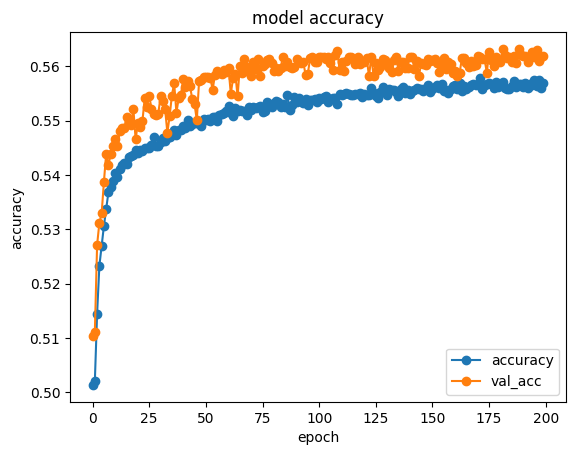

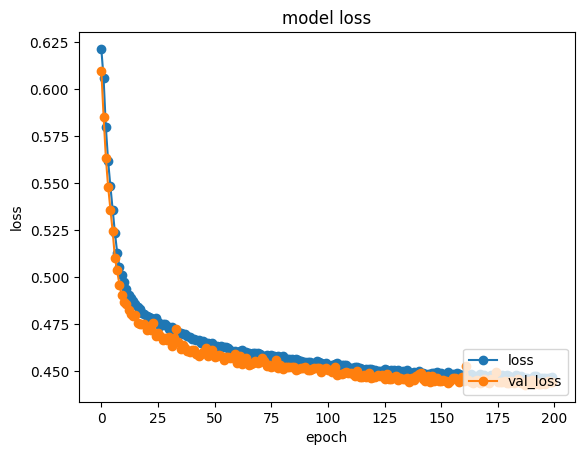

=== History 1 ===


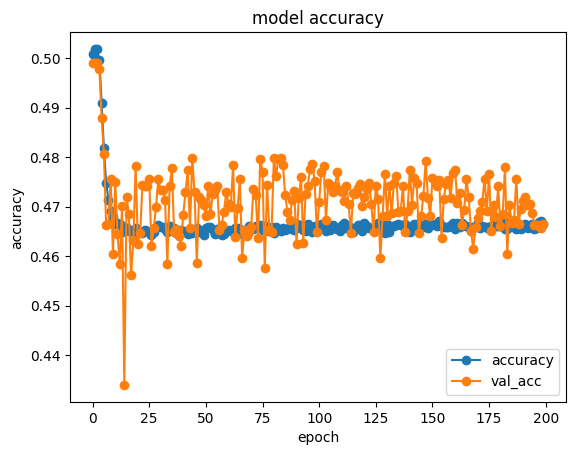

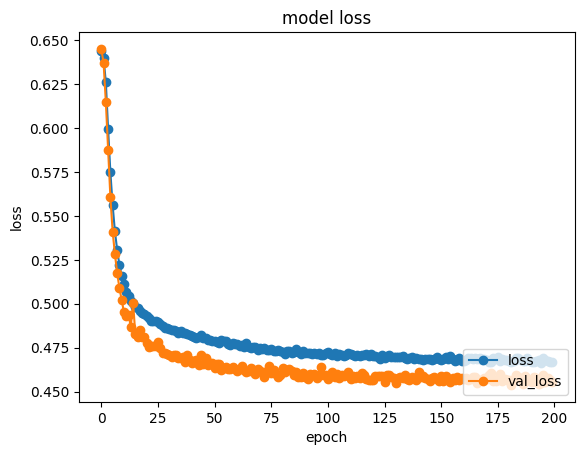

=== History 2 ===


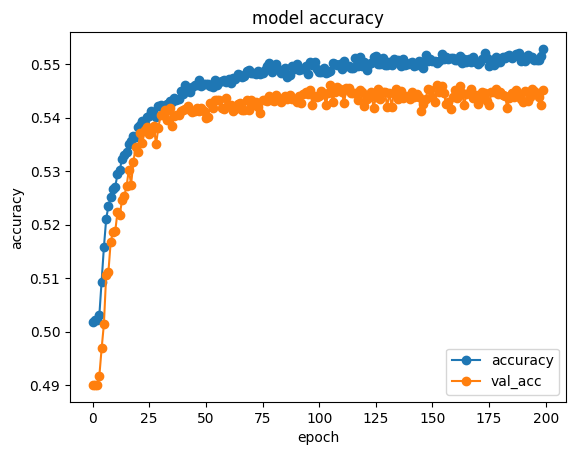

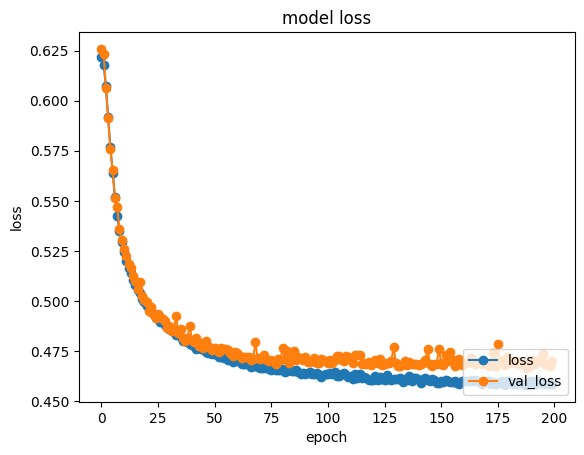

=== History 3 ===


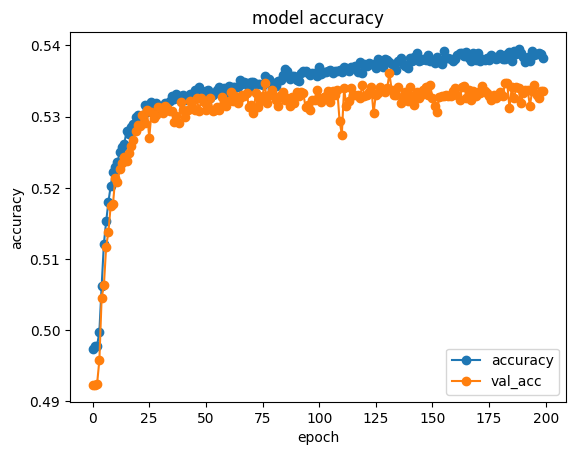

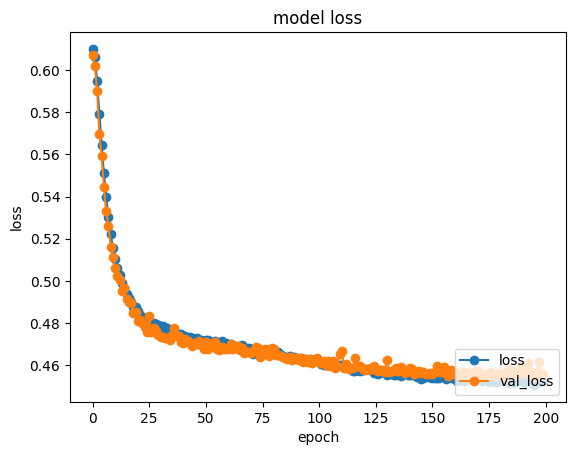

=== History 4 ===


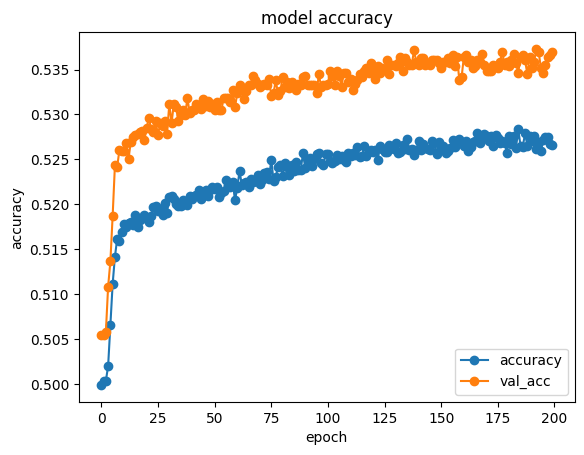

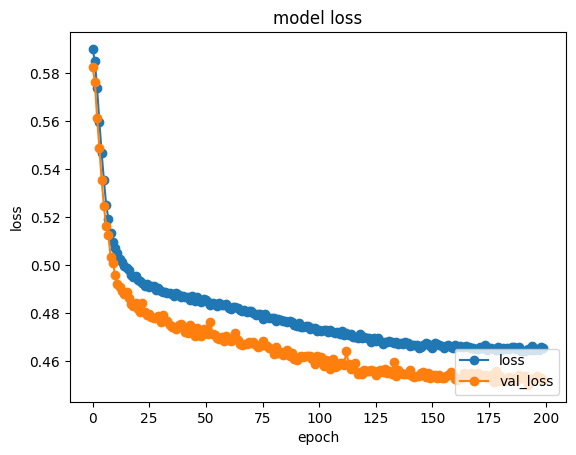

=== History 5 ===


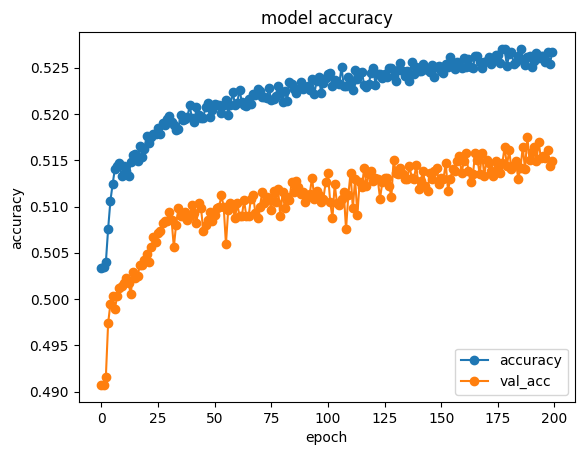

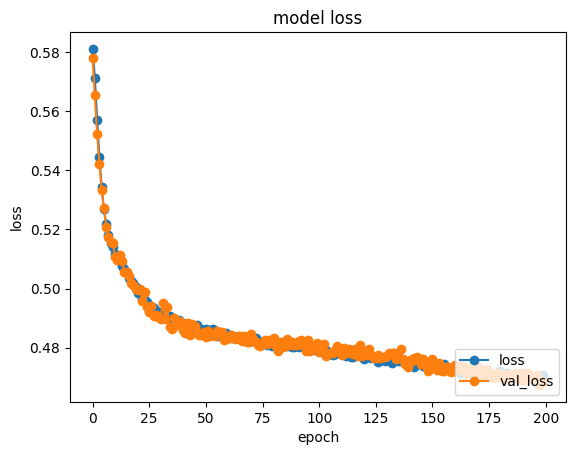

=== History 6 ===


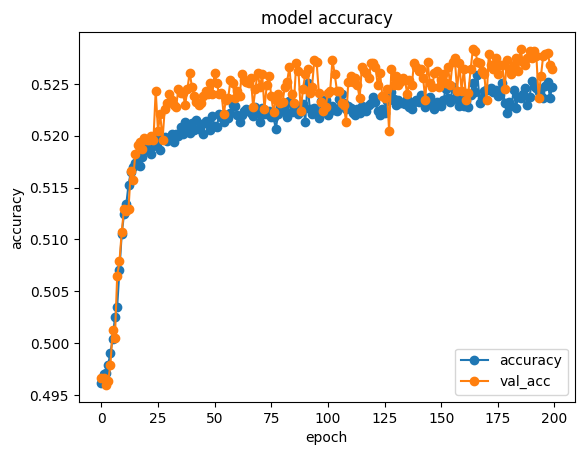

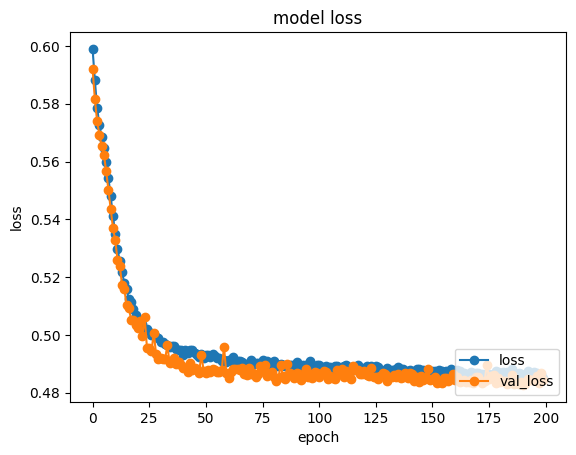

=== History 7 ===


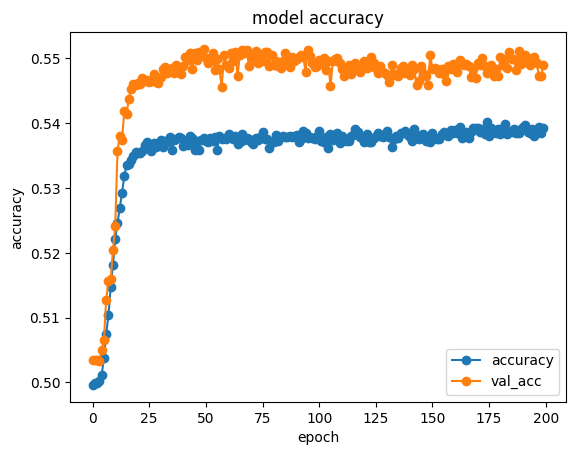

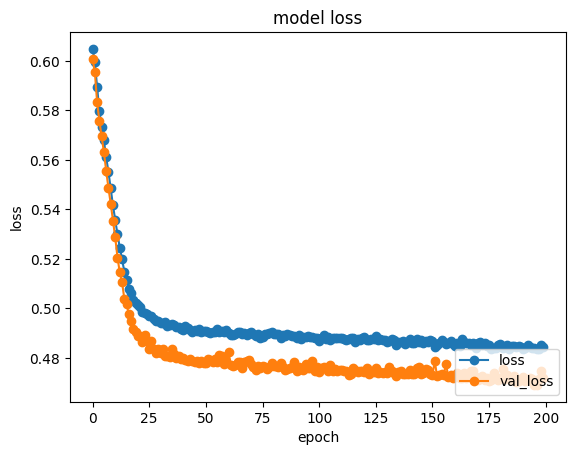

=== History 8 ===


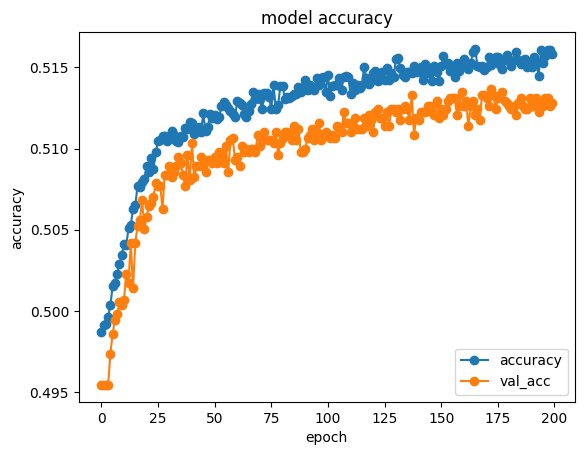

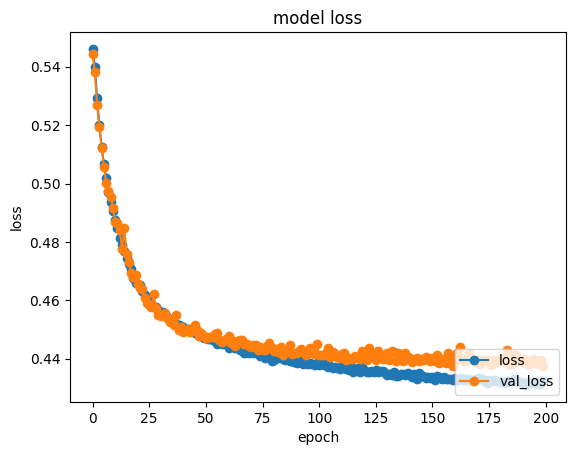

=== History 9 ===


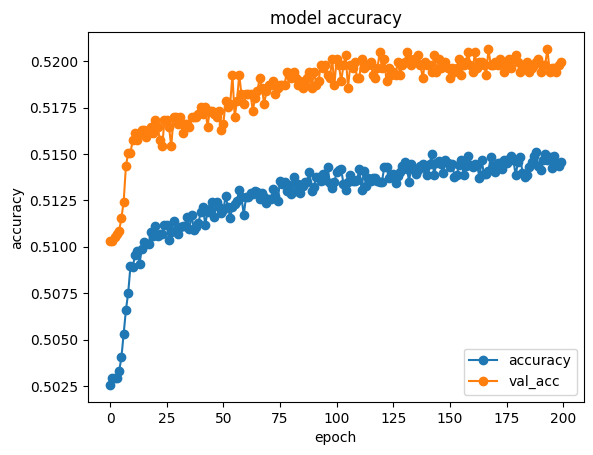

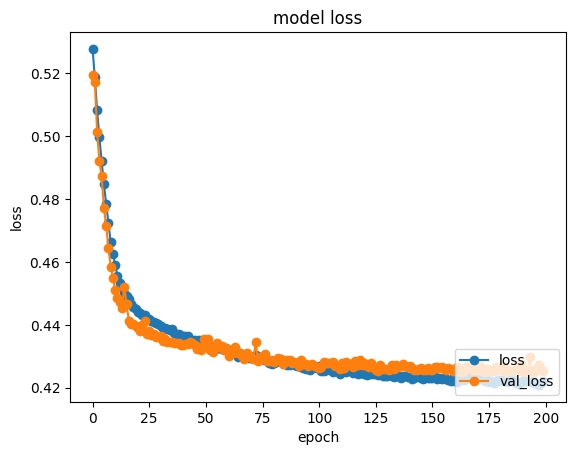

=== History 10 ===


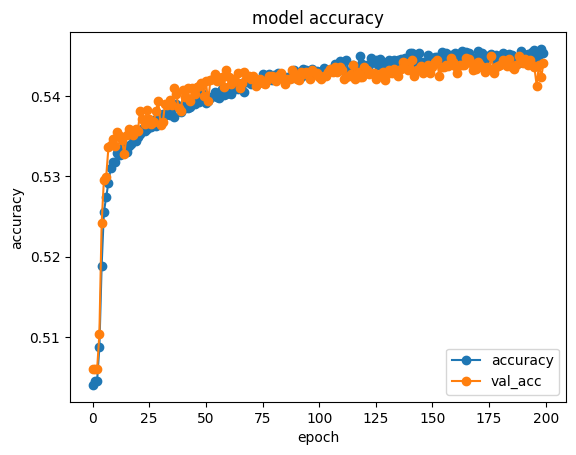

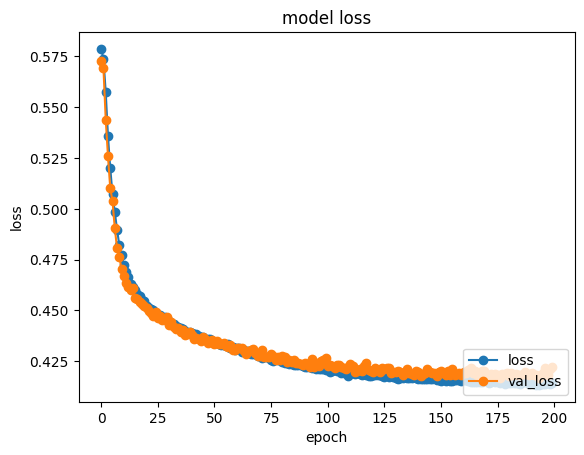

=== History 11 ===


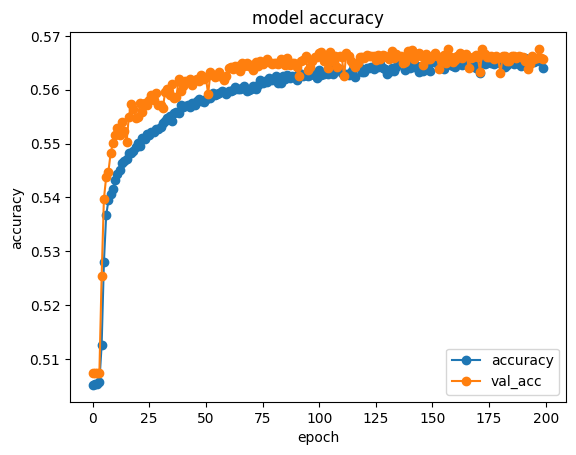

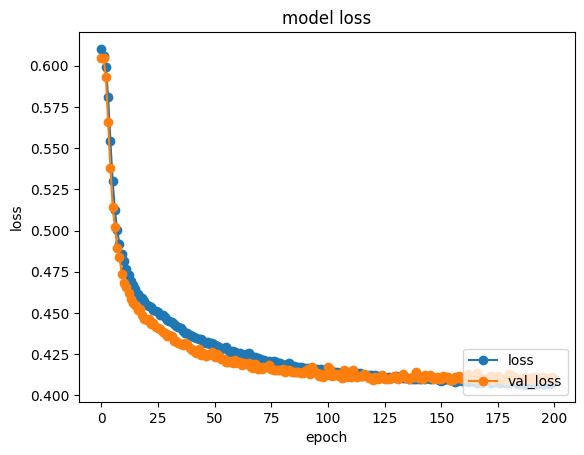

=== History 12 ===


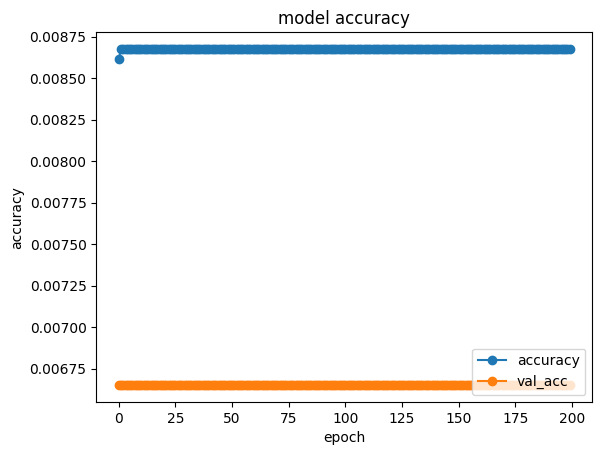

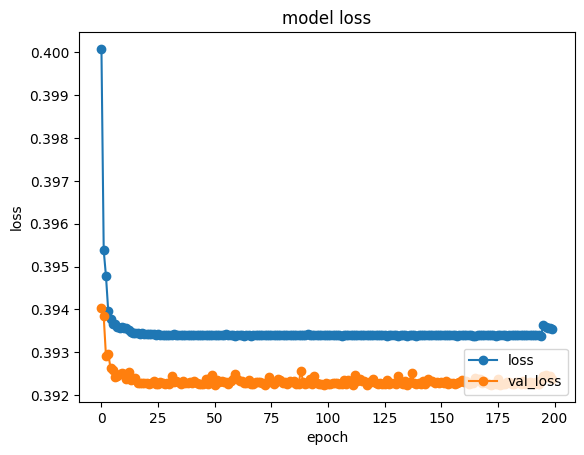

=== History 13 ===


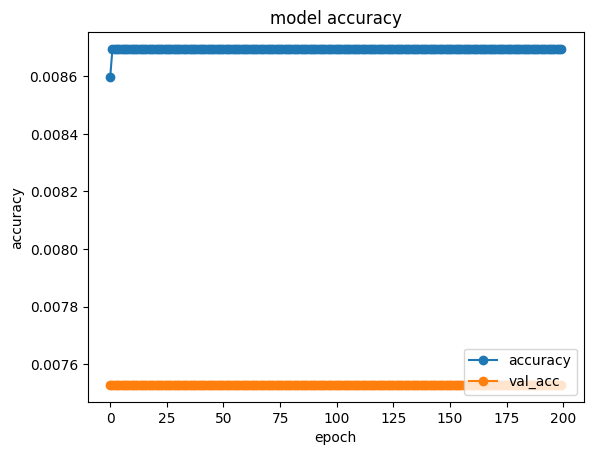

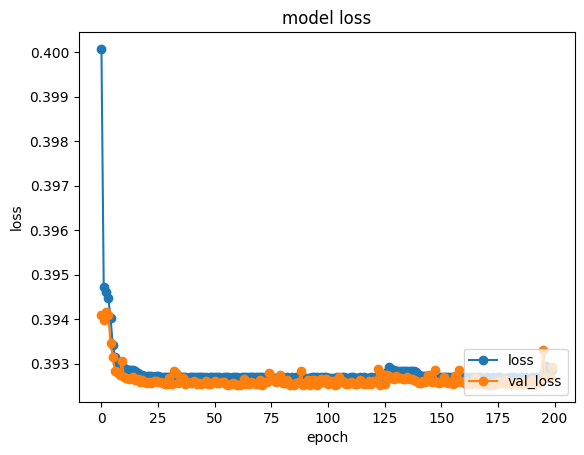

=== History 14 ===


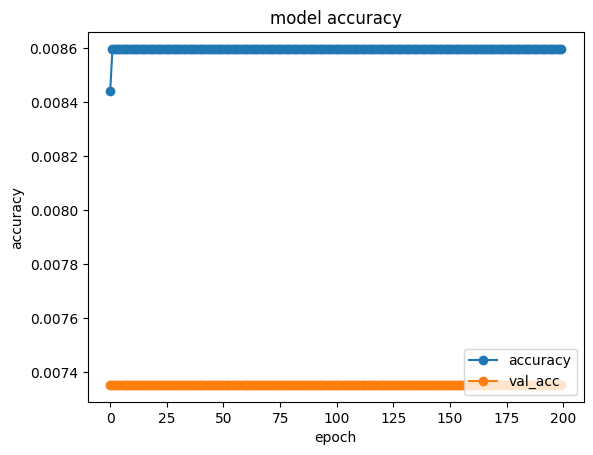

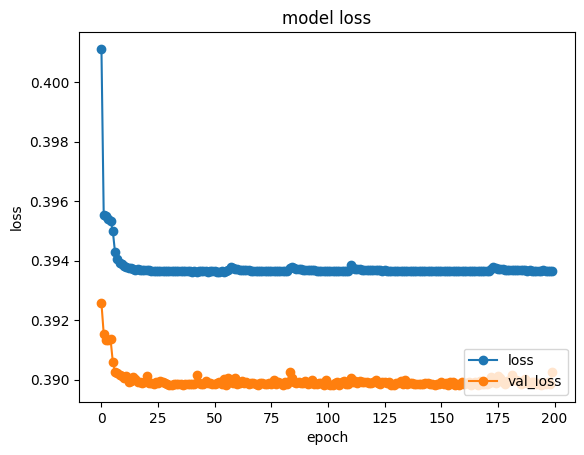

=== History 15 ===


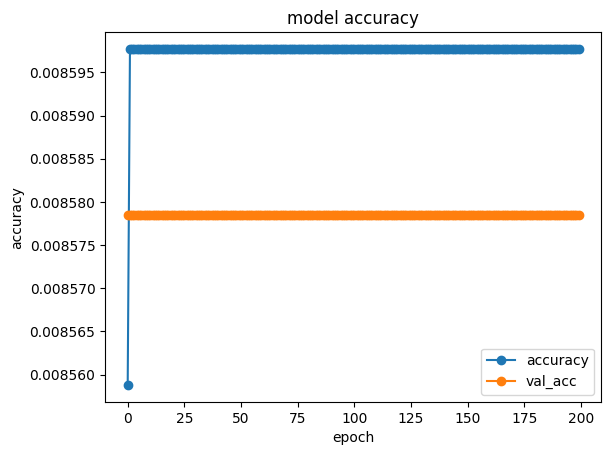

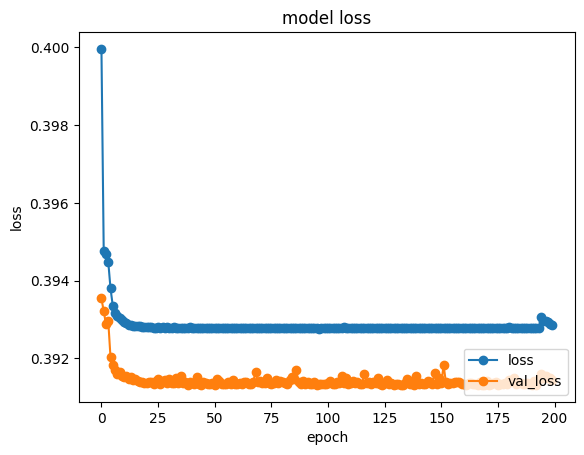

=== History 16 ===


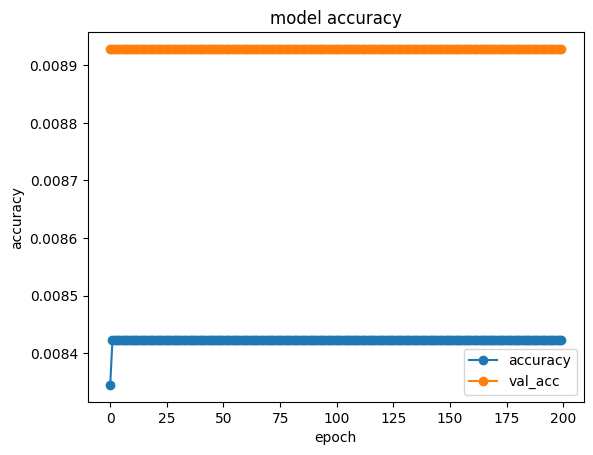

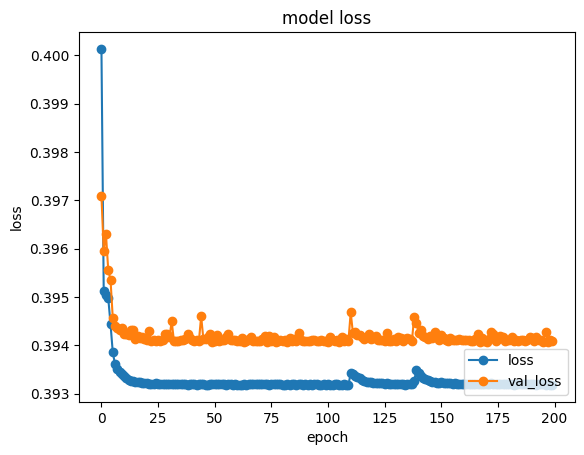

=== History 17 ===


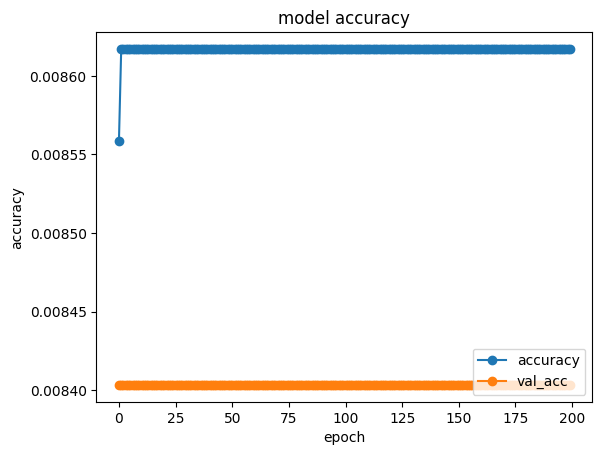

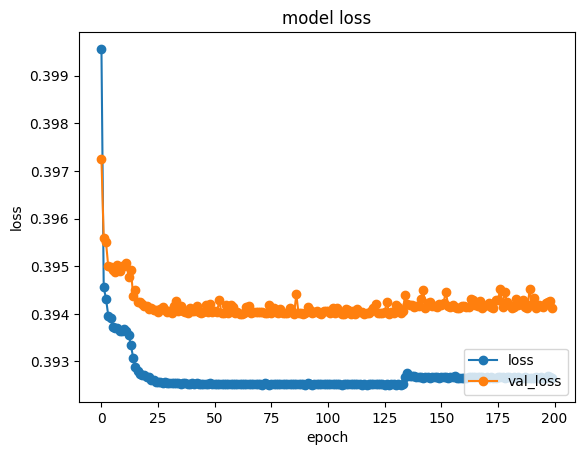

=== History 18 ===


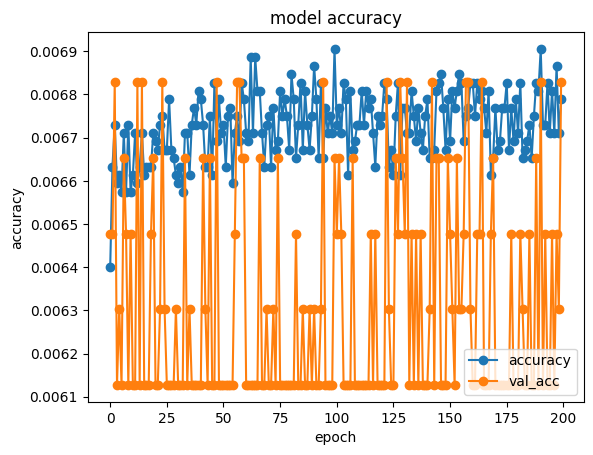

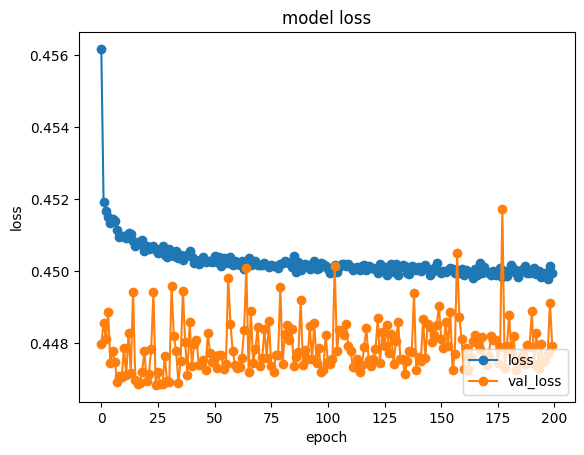

=== History 19 ===


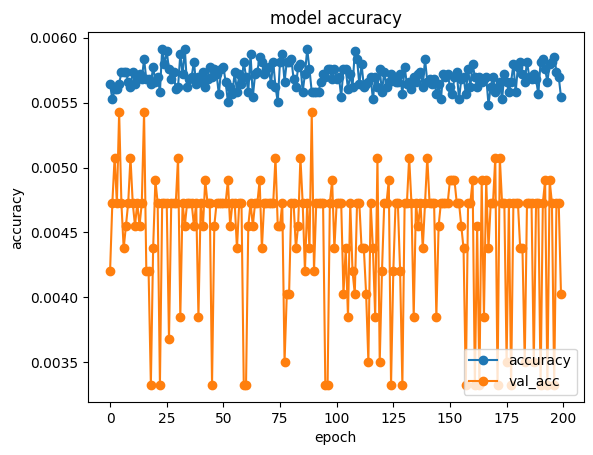

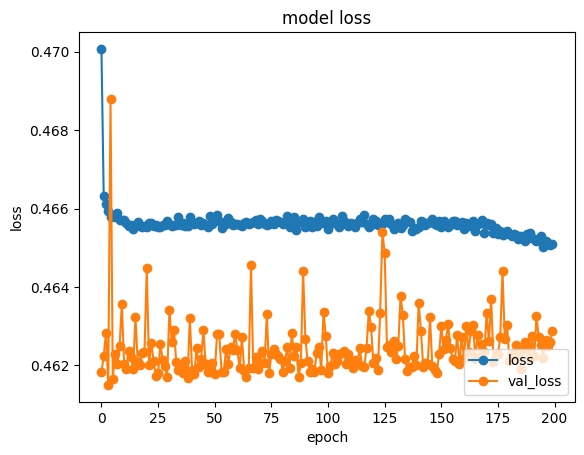

In [13]:
# loss 遷移のプロット

!pip install matplotlib

import matplotlib.pyplot as plt

for i in range(x.shape[2]):
    print("=== History " + str(i) + " ===")
    plot_history(histories[i])

In [11]:
# 楽曲の出力

import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from keras.models import load_model
import soundfile as sf

def add_fade(x, ft_len):
    r = np.arange(0, ft_len)*np.pi/ft_len
    w_fo = (0.5+0.5*np.cos(r))**0.5
    w_fi = (0.5-0.5*np.cos(r))**0.5
    
    x[0:ft_len]        *= w_fi
    x[clip_size-ft_len::] *= w_fo
    return x

def gen_xfade(x_pre, x_next, ft_len):
    if x_pre is None:
        xfade = x_next
    else:
        x_pre_begin = x_pre[:x_pre.shape[0] - ft_len]
        x_pre_end = x_pre[x_pre.shape[0] - ft_len:]
        x_pre_len = clip_size
        x_next_len = clip_size
        x_pre_len -= ft_len
        x_next_len -= ft_len
        xfade = np.concatenate((x_pre_begin, np.concatenate((x_pre_end, np.zeros(x_next_len))) + x_next))
    return xfade

def create_music_consider_weights(fname, rw):
    first_index = np.random.randint(0, len(cqt_chromas))
    predict_index = first_index
    out = None
    fade_samples = 10240
    
    for i in range(num_clips):
        print("-- generate " + str(i + 1) + " / " + str(num_clips))
        predict_vec = np.zeros((0, ))
        for i in range(x.shape[2]):
            predict = models[i].predict(np.array([cqt_chromas[predict_index, :-1]]))[0] * (y_maxs[i] - y_mins[i]) + y_mins[i]
            predict_vec = np.hstack((predict_vec, predict))
        predict_chroma = predict_vec[:len(predict_vec)-num_divide]
        predict_rhythm = predict_vec[len(predict_vec)-num_divide:]

        index = 0
        similar_index = 0
        score = -1 - rw
        chroma_score = 0
        rhythm_score = 0
        for cqt_chroma in cqt_chromas[:, (int)(fade_samples / hop_size)]:
            cqt_chroma_chroma = cqt_chroma[:len(cqt_chroma)-num_divide]
            cqt_chroma_rhythm = cqt_chroma[len(cqt_chroma)-num_divide:]
            tmp_chroma_score = cosine_similarity(np.array([predict_chroma]), np.array([cqt_chroma_chroma]))
            tmp_rhythm_score = cosine_similarity(np.array([predict_rhythm]), np.array([cqt_chroma_rhythm]))
            tmp_score = tmp_chroma_score + rw * tmp_rhythm_score
            if tmp_score > score:
                score = tmp_score
                similar_index = index
            index += 1

        print("score: " + str(score))
        print("predict_vec: " + str(predict_vec))
        print("cqt_chromas[similar_index]: " + str(cqt_chromas[similar_index, 0]))
        print("similar_index: " + str(similar_index))
        print("--")

        predict_index = similar_index

        tmp = add_fade(clips[predict_index], fade_samples)
        out = gen_xfade(out, tmp, fade_samples)
        
    sf.write(fname, out, SAMPLING_RATE, subtype="PCM_16")

models = []
for i in range(x.shape[2]):
    model_name = "independent_" + data_name + "_batch" + str(batch_size) + "_e" + str(epochs) + "_" + str(i)
    
    models.append(load_model("../data/models/" + model_name))

num_clips = 30

for i in range(7):
    rhythm_weight = (4.0 + i) / (10.0 - i)
    file_name = "out_" + "independent_" + data_name + "_batch" + str(batch_size) + "_e" + str(epochs) + "_rw" + format(rhythm_weight, '.2f').replace('.', '_')
    fname = "../data/out/" + file_name + "_track" + str(i) + ".wav"
    print("creating " + fname + " ...")
    create_music_consider_weights(fname, rhythm_weight)